In [4]:
import torch
import faces_model
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable
from net_sphere import sphere20a
from open_face_model import OpenFace
import matplotlib.pyplot as plt

import torchvision

import torch.nn as nn

from datasets import celebA
from data_utils import *

In [5]:
class ZeroPadBottom(object):
    ''' Zero pads batch of image tensor Variables on bottom to given size. Input (B, C, H, W) - padded on H axis. '''
    def __init__(self, size, use_gpu=True):
        self.size = size
        self.use_gpu = use_gpu
        
    def __call__(self, sample):
        B, C, H, W = sample.size()
        diff = self.size - H
        padding = Variable(torch.zeros(B, C, diff, W), requires_grad=False)
        if self.use_gpu:
            padding = padding.cuda()
        zero_padded = torch.cat((sample, padding), dim=2)
        return zero_padded

In [8]:
f_model = OpenFace(False, 0)
f_model.load_state_dict(torch.load('./pretrained_model/openface.pth'))
f_model = f_model.eval()

RuntimeError: Cannot initialize CUDA without ATen_cuda library. PyTorch splits its backend into two shared libraries: a CPU library and a CUDA library; this error has occurred because you are trying to use some CUDA functionality, but the CUDA library has not been loaded by the dynamic linker for some reason.  The CUDA library MUST be loaded, EVEN IF you don't directly use any symbols from the CUDA library! One common culprit is a lack of -Wl,--no-as-needed in your link arguments; many dynamic linkers will delete dynamic library dependencies if you don't depend on any of their symbols.  You can check if this has occurred by using ldd on your binary to see if there is a dependency on *_cuda.so library.

In [147]:
model = torch.load('/home/jneha0906/new_dt/old_log_backup/1543634366_10_1229.tar')

In [130]:
train_set = celebA.CelebA(data_dir = './data/celebA/images', annotations_dir='./data/celebA/annotations', split='train', transform = transforms.Compose([ResizeTransform(96)]))

init done


In [131]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True) #TODO: why does shuffle give out of bounds indices?

In [148]:
data_iter = iter(train_loader)
img_tens = data_iter.next()
img_tens = img_tens.cuda()
img_v = Variable(img_tens, requires_grad=False)
f, f_736 = f_model(img_v)
print(f.size(), f_736.size())

(torch.Size([1, 128]), torch.Size([1, 736]))


In [154]:
s_G = model['G_model'](torch.cat((f, f_736), dim=1))
up96 = nn.Upsample(size=(96,96), mode='bilinear')
s_G = up96(s_G)
s_G = s_G.cpu().data
unnorm_emoji = UnNormalizeRangeTanh()
res = unnorm_emoji(s_G[:16])

In [150]:
npimg = torchvision.utils.make_grid(res, nrow=4).numpy()
npimg = np.transpose(npimg, (1, 2, 0)) 
zero_array = np.zeros(npimg.shape)
one_array = np.ones(npimg.shape)
npimg = np.minimum(npimg,one_array)
npimg = np.maximum(npimg,zero_array)

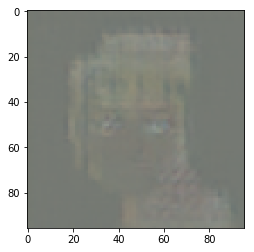

In [151]:
plt.imshow(npimg)

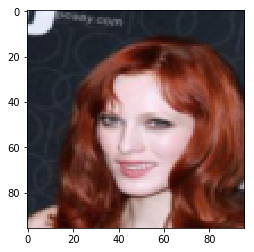

In [152]:
npimg2 = torchvision.utils.make_grid(img_tens.cpu(), nrow=4).numpy()
npimg2 = np.transpose(npimg2, (1, 2, 0)) 
zero_array2 = np.zeros(npimg2.shape)
one_array2 = np.ones(npimg2.shape)
npimg2 = np.minimum(npimg2,one_array2)
npimg2 = np.maximum(npimg2,zero_array2)
plt.imshow(npimg2)

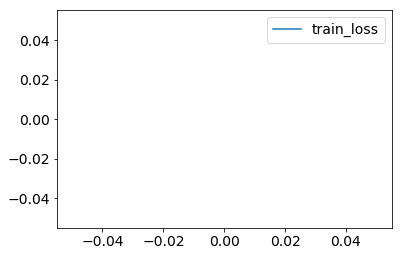

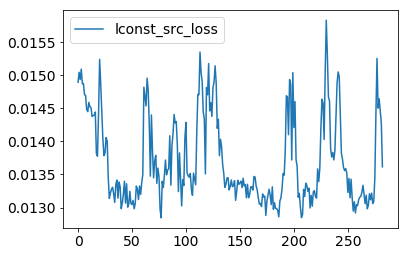

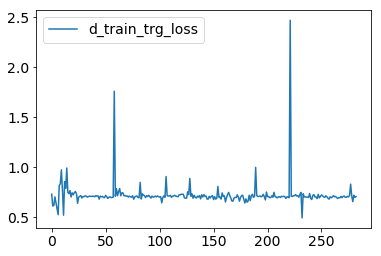

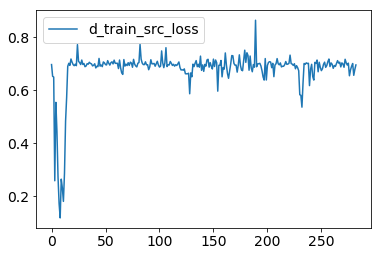

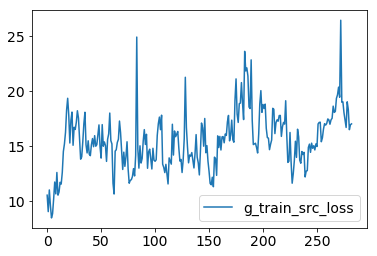

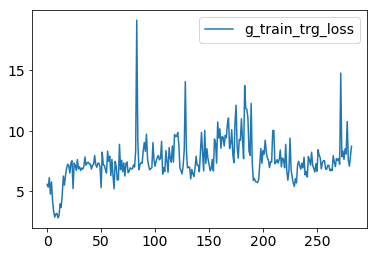

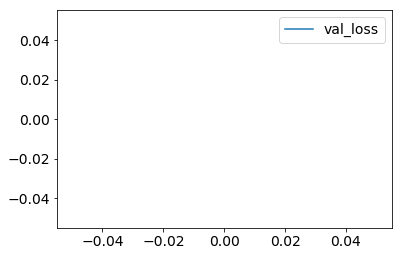

In [157]:
import matplotlib
plt.figure()
matplotlib.rcParams['font.size'] = 14
for key in model:
    if 'loss' in key and model[key] is not None:
        y = model[key][2:]
        x = np.arange(0, 11450, 50)
        plt.plot(y,label=key)
        plt.legend()
#         plt.ylabel('Loss')
#         plt.xlabel('Batches (size 128)')
        plt.show()